# Goal

There is a need to respond quickly to changes in today's world. This response may sometimes require understanding of a topic. Given any topic, there is a plethora of sources providing seas of data related to the it. Given todays world condition, a global concern is the treatment and handling of the COVID-19 pandemic. Given the rising amount of literature regarding the subject, it will be difficult for a scientist to keep up with today's literature.
> Is it possible to cluster these tens of thousands of articles to make it easier for a scientist to find relevant research articles?



In [1]:
from datetime import datetime
start_time = datetime.now()
import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
from hdfs import InsecureClient

end_time = datetime.now()
print(f'Time for imports only: {end_time-start_time}')

Time for imports only: 0:00:01.113192


## Reading all files into Spark RDDs with PySpark

In [2]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("SparkTFIDF")
sc = SparkContext(conf=conf)

hdfs_folder = 'hdfs://madison:31802/cord19dataset/metadata.csv'

def read_data(hdfs_folder):
    data = sc.parallelize([])
    data = sc.textFile(hdfs_folder)
    return data

meta = read_data(hdfs_folder)
sc.stop()

In [3]:
meta

hdfs://madison:31802/cord19dataset/metadata.csv MapPartitionsRDD[2] at textFile at NativeMethodAccessorImpl.java:0

## Reading all files from HDFS

In [4]:
client_hdfs = InsecureClient('http://madison:31802')

In [5]:
client_hdfs.content('/cord19dataset')

{'directoryCount': 17,
 'fileCount': 59317,
 'length': 7913288034,
 'quota': -1,
 'spaceConsumed': 23739864102,
 'spaceQuota': -1,
 'typeQuota': {}}

In [6]:
fnames = client_hdfs.list('/cord19dataset')
fnames

['COVID.DATA.LIC.AGMT.pdf',
 'biorxiv_medrxiv',
 'biorxiv_medrxiv.tar.gz',
 'comm_use_subset',
 'cord19_specter_embeddings_2020-04-10',
 'custom_license',
 'json_schema.txt',
 'metadata.csv',
 'metadata.readme',
 'noncomm_use_subset']

In [6]:
fnames = client_hdfs.list('/cord19dataset/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json')
fnames[0:50]

['0015023cc06b5362d332b3baf348d11567ca2fbb.json',
 '00340eea543336d54adda18236424de6a5e91c9d.json',
 '004f0f8bb66cf446678dc13cf2701feec4f36d76.json',
 '00911cf4f99a3d5ae5e5b787675646a743574496.json',
 '00d16927588fb04d4be0e6b269fc02f0d3c2aa7b.json',
 '00eb9220dc8cd351393b6b035323d350f103f8c6.json',
 '0139ea4ca580af99b602c6435368e7fdbefacb03.json',
 '013d9d1cba8a54d5d3718c229b812d7cf91b6c89.json',
 '018fb5e62fbbcae07d57d94d29ac630dcc4dccf9.json',
 '01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18.json',
 '01e3b313e78a352593be2ff64927192af66619b5.json',
 '02201e4601ab0eb70b6c26480cf2bfeae2625193.json',
 '0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5.json',
 '029c1c588047f1d612a219ee15494d2d19ff7439.json',
 '0313c3faa16cd66d64f31ae37e40fb70695d69fb.json',
 '033ea7af3e6137df652de026f0751ac435327b75.json',
 '03813d8657ba43ea382788caec2d14257b26d8fd.json',
 '03ce432f27c7df6af22b92245a614db2ecb5de5f.json',
 '03ea3a614b56409d3f099c9ad764864293132540.json',
 '03ea9ad47ebe9a599205b99390c45490e6724024.json',


In [8]:
##It is possible to loop through all the folders and sub folders while using 
##content(<path>,strict=False) != None as a breaking condition`

In [7]:
#There is also this provided snippet to get all files under a given directory
# Get all files under a given folder (arbitrary depth).
import posixpath as psp
fpaths = [
  psp.join(dpath, fname)
  for dpath, _, fnames in client_hdfs.walk('/cord19dataset')
  for fname in fnames
]
len(fpaths)

59317

In [9]:
fpaths_json = list(filter(lambda x: ".json" in x,fpaths))

len(fpaths_json)

59311

In [10]:
_125hdfsjson = fpaths_json[0:12500]

## Metadata for the database

We are given a metadata file that gives us the filename of each article along with its abstract and some other details such as date published and journal that it was published in.

In [11]:
root_path = '/cord19dataset'

In [12]:
with client_hdfs.read(f'{root_path}/metadata.csv', encoding = 'utf-8') as reader:
    meta = pd.read_csv(reader)

meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [13]:
meta.count()

cord_uid                       51078
sha                            38022
source_x                       51078
title                          50920
doi                            47741
pmcid                          41082
pubmed_id                      37861
license                        51078
abstract                       42352
publish_time                   51070
authors                        48891
journal                        46368
Microsoft Academic Paper ID      964
WHO #Covidence                  1768
has_pdf_parse                  51078
has_pmc_xml_parse              51078
full_text_file                 42511
url                            50776
dtype: int64

In [14]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
cord_uid                       51078 non-null object
sha                            38022 non-null object
source_x                       51078 non-null object
title                          50920 non-null object
doi                            47741 non-null object
pmcid                          41082 non-null object
pubmed_id                      37861 non-null float64
license                        51078 non-null object
abstract                       42352 non-null object
publish_time                   51070 non-null object
authors                        48891 non-null object
journal                        46368 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_pdf_parse                  51078 non-null bool
has_pmc_xml_parse              51078 non-null bool
full_text_file                 42511 non-null ob

Let us look at the column marked "SHA". At a closer look, we can see that it seems to be a hash of some kind.

But looking into the folders, we see that this unique hash has been ingeniously used to identify each file. i.e. We don't need to refer to a long paper title to find its file contents. Instead we can just scan the home directory for a file with that hash.json.

In [15]:
meta["sha"][0]

'1e1286db212100993d03cc22374b624f7caee956'

In [17]:
bio= meta.loc[meta['source_x'] == 'biorxiv']
bio.head()
bio.iloc[1]['sha']

'daf32e013d325a6feb80e83d15aabc64a48fae33'

Now the source_x column is of importance for us as well. It refers to the source journal of each paper. This is important because the papers have been organized into folders, each representing a different source. e.g. a biorxiv folder, a WHO document folder etc.

In [18]:
meta.source_x.unique()

array(['PMC', 'Elsevier', 'CZI', 'WHO', 'biorxiv', 'medrxiv'],
      dtype=object)

Let us read some of the biorxiv files into variables to see the structure as viewed in the screenshot before section 2.1.

In [19]:
for i in range(1):
    with client_hdfs.read(fpaths_json[i]) as reader:
        from json import load
        print(load(reader))

{'paper_id': '0015023cc06b5362d332b3baf348d11567ca2fbb', 'metadata': {'title': 'The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'a

In [20]:
articles = {}
for i in range(1):
    with client_hdfs.read(fpaths_json[i]) as reader:
        from json import load
        articles[i] = load(reader)

articles[0].keys()

dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])

From above, we can see that there are keys that describe each paper of the biorxiv journal. Of these, Our paritcular interest lies in the abstract and the body_text. The title is useful too, and to get it, we have to look inside the metadata part of the file. 

In [21]:
articles[0]['metadata'].keys()

dict_keys(['title', 'authors'])

If printed as a whole, each file would look like the below output:

In [22]:
with client_hdfs.read(f'{fpaths_json[0]}', encoding = 'utf-8') as reader:
    f = json.load(reader)
    print(type(f),f['metadata'])

<class 'dict'> {'title': 'The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Morgan', 'mi

In [23]:
with client_hdfs.read(f'{fpaths_json[0]}', encoding = 'utf-8') as reader:
    f = json.load(reader)
    for line in f:
        print(line)

paper_id
metadata
abstract
body_text
bib_entries
ref_entries
back_matter


## How to load and read a json file

In [24]:
def load_json(filename):
    with open(filename +  ".json") as f:
        data = json.load(f)
    return data

## Reading all files from local disk

Since our dataset is not prohibitively large(7-8GB) it is easilty possible to reado it from disk as shown below

Code to read all json files in the directory in one go (Cite: [Kernel on Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering))

In [ ]:
start_time = datetime.now()
all_json = glob.glob(f'/s/chopin/b/grad/sanketm/cord19dataset/**/*.json', recursive=True)
end_time = datetime.now()
print(f'Loaded the paths of {len(all_json)} files from disk. Took {end_time-start_time}')

In [ ]:
all_json[0]

In [ ]:
_125json = all_json[0:12500]
_125json[0]

In [ ]:
fpaths_json[0]

Let's make a class so that we could refer to the loaded articles easily

In [16]:
class Article:
    
    def __init__(self,filepath):
        with client_hdfs.read(filepath,encoding='utf=8') as f:
            metadata = json.load(f)
            self.paper_id = metadata['paper_id']
            self.title = metadata['metadata']['title']
            self.abstract = ""
            self.body_text = ""
            
            #Abstract
            try:
                for entry in metadata['abstract']:
                    self.abstract += str(entry['text'])
            except:
                pass
                
            

            #body_text
            for entry in metadata['body_text']:
                self.body_text += str(entry['text'])


            
    def __repr__(self):
        return f'Article Object with id: {self.paper_id} \n title:{self.title} \n abstract:{self.abstract}'
            
                       

In [26]:
articles = {}
for i in range(2):
        print(Article(fpaths_json[i]),"\n\n\n\n")

Article Object with id: 0015023cc06b5362d332b3baf348d11567ca2fbb 
 title:The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3 
 abstract:word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). 

In [27]:
articles = {}
for i in range(2):
        articles[i] = Article(fpaths_json[i])

In [28]:
articles[0].abstract

'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAP

In [29]:
articles[1]

Article Object with id: 00340eea543336d54adda18236424de6a5e91c9d 
 title:Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications 
 abstract:During the past three months, a new coronavirus (SARS-CoV-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. A plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate SARS-CoV-2 genetic heterogeneity and spatiotemporal dissemination. We examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. Our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. Hence the need for avoiding sti

# Data Cleaning

Now that we have explored the structure of the dataset, let us focus on our areas of interest as mentioned earlier: namely the Title, Abstract and the body of the text.\
We know that we can access these for a given paper by scanning the metadata for a paper of choice for its title and abstract, and if we need it, using its `sha` column value to get the full text of the paper.

First let us clean the metadata by dropping all NA valued rows for the title, sha and abstract columns.

[Pandas filter rows](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

In [ ]:
bio= meta.loc[meta['source_x'] == 'biorxiv']

print(f'Meta count:{len(meta)} biorxiv papers count: {len(bio)}')

bio_clean = bio.drop_duplicates().dropna()

len(bio_clean)

Using the above dropna condition doesn't work out,  number of rows in the resulting dataframe is zero.
We found a solution Cite: [stack overflow post](https://stackoverflow.com/questions/39241346/pandas-dropna-on-specify-attribute)

In [ ]:
bio_clean = bio.loc[~(bio.sha.isnull())]

len(bio_clean)

bio_clean.head()

Now we can remove columns that are unneeded or have only nan values

In [ ]:
print(bio_clean['source_x'].unique(),
bio_clean['pmcid'].unique(),
bio_clean['pubmed_id'].unique(),
bio_clean['Microsoft Academic Paper ID'].unique(),
bio_clean['WHO #Covidence'].unique())

In [ ]:
bio_slim = bio_clean.drop(['Microsoft Academic Paper ID','WHO #Covidence','pubmed_id','pmcid'], axis = 1)

bio_slim = bio_slim.drop(['url','doi','license','full_text_file'],axis =1 )

bio_slim = bio_slim[~bio_slim.has_pdf_parse.isin(['False'])]

bio_slim =bio_slim.loc[~(bio_slim.abstract.isnull())]

As we had seen at the send of section 2.3, `fpaths_json` contains the paths of all the json files(i.e. the articles) in it.
Now we should load this into a dataframe for it to be queryable

In [27]:
start_time = datetime.now()
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': []}
for idx, entry in enumerate(_125hdfsjson):
    if idx % (len(_125hdfsjson) // 10) == 0:
        print(f'Processing index: {idx} of {len(_125hdfsjson)}')
    content = Article(entry)
    
    # get metadata information
    meta_data = meta.loc[meta['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    

    dict_['body_text'].append(content.body_text)
    
       
    # get metadata information
    meta_data = meta.loc[meta['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = meta_data['title'].values[0], 40
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
       
    dict_['paper_id'].append(meta_data['sha'].values[0])
    dict_['abstract'].append(meta_data['abstract'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title'])
df_covid.head()
end_time = datetime.now()
print(f' time taken : {(end_time  - start_time)}')

Processing index: 0 of 12500
Processing index: 1250 of 12500
Processing index: 2500 of 12500
Processing index: 3750 of 12500
Processing index: 5000 of 12500
Processing index: 6250 of 12500
Processing index: 7500 of 12500
Processing index: 8750 of 12500
Processing index: 10000 of 12500
Processing index: 11250 of 12500
 time taken : 0:07:19.230393


In [28]:
print(len(dict_['paper_id']),len(dict_['abstract']),len(dict_['body_text']),len(dict_['authors']),len(dict_['title']))

len(df_covid['abstract'][0].strip().split())

10298 10298 10298 10298 10298


194

In [29]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(str(x).strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(str(x).strip().split()))
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head(10)

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,AbstractThe positive stranded RNA genomes of p...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,ABSTRARCTThe fast accumulation of viral metage...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,AbstractInfectious bronchitis (IB) causes sign...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199
5,00eb9220dc8cd351393b6b035323d350f103f8c6,"Importance: As with other traumatic events, pa...","Evidence from prior pandemics suggests that, a...",Victor M. Castro. Roy H Perlis,(Impact of COVID-19 on psychiatric assessment ...,246,2103,759
6,0139ea4ca580af99b602c6435368e7fdbefacb03,AbstractBackgroundNipah Virus (NiV) came into ...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,(A Combined Evidence Approach to Prioritize Ni...,326,2382,1034
7,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,(Assessing spread risk of Wuhan novel coronavi...,292,4596,1205
8,018fb5e62fbbcae07d57d94d29ac630dcc4dccf9,Introduction: Recent events highlight how emer...,Recent events highlight how emerging and re-em...,DAVIDE GORI. Erik Boetto...,(Analysis of the scientific literature in the ...,200,2906,1131
9,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...,Xiaoyang Ji. Chunming Zhang...,"(TWIRLS, an automated topic-wise inference met...",223,4386,1309


# Checkpoint!!

In [50]:
df_covid.to_csv("./df_covid.csv",index=False)

## Dataset statistics <a id='Statistics'></a>

In [ ]:
totalnumberofwords_abstract=df_covid['abstract_word_count'].sum()
avg_abstract_len = totalnumberofwords_abstract/len(df_covid['abstract_word_count'])
print(f'Total number of words across all abstracts = {totalnumberofwords_abstract}. Average abstract length = {avg_abstract_len}')

In [ ]:
totalnumberofwords_body=df_covid['body_word_count'].sum()
avg_body_len = totalnumberofwords_body/len(df_covid['body_word_count'])
print(f'Total number of words across all body texts = {totalnumberofwords_body}. Average body length = {avg_body_len}')

In [ ]:
uniqwords = df_covid['body_unique_words'].sum()
avg_uniq_words = uniqwords/len(df_covid['body_unique_words'])
print(f'Total number of unique words across all body texts: {uniqwords}.')

In [ ]:
#plot = plt.figure(figsize=(80,80))
ax1 = plt.subplot(2,1,1)
ax1.plot(df_covid['abstract_word_count'])
#plt.xlim(right=2500)
ax1.set_title("Abstract word-count")

In [ ]:
#plot = plt.figure(figsize=(100,108))
ax2 = plt.subplot(2,1,2)
ax2.plot(df_covid['body_word_count'])
ax2.set_title("Article body-text word-count")

In [ ]:
import seaborn as sns
sns.distplot(df_covid['body_word_count'])
df_covid['body_word_count'].describe()

In [ ]:
sns.distplot(df_covid['body_unique_words'])
df_covid['body_unique_words'].describe()

In [ ]:
sns.distplot(df_covid['abstract_word_count'])
df_covid['abstract_word_count'].describe()

In [ ]:
df_covid.info()

In [ ]:
df_covid['abstract'].describe(include='all')

The difference between the unique count and the total count means that either there are some duplicate abstracts or there are blank abstracts that are being counted as the same. 

In [ ]:
df_covid['body_text'].describe(include='all')

The difference between the unique count and the total count means that there are some duplicate articles present in the dataset. This coulde be possible if the authors had sent their papers to different journals.

In [ ]:
df_covid.drop_duplicates(['abstract'],inplace=True)

df_covid['abstract'].describe(include='all')

In [ ]:
df_covid.drop_duplicates(['body_text'],inplace=True)

df_covid['body_text'].describe(include='all')

In [ ]:
df_covid.info()

In [ ]:
df_covid.describe()

# Data Preprocessing

We now clean the text data so that our key words are clear and we do not have to worry about details we are not concerned about. [ref1](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79)  [ref2](https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/)

Firstly By now looking at the abstract columns, we must notice that the text scraped from these articles is not perfect.

For example, many of the abstracts start with the word *Abstract* glued to the beginning of the first word of the real abstract body. 

## Cleaning dirty abstracts

In [30]:
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('Abstract',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('abstract',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('ABSTRACT',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('ABSTRARCT',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('Background',''))
df_covid.head(10)

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,The positive stranded RNA genomes of picornavi...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199
5,00eb9220dc8cd351393b6b035323d350f103f8c6,"Importance: As with other traumatic events, pa...","Evidence from prior pandemics suggests that, a...",Victor M. Castro. Roy H Perlis,(Impact of COVID-19 on psychiatric assessment ...,246,2103,759
6,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,(A Combined Evidence Approach to Prioritize Ni...,326,2382,1034
7,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,: A novel coronavirus (2019-nCoV) emerged in W...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,(Assessing spread risk of Wuhan novel coronavi...,292,4596,1205
8,018fb5e62fbbcae07d57d94d29ac630dcc4dccf9,Introduction: Recent events highlight how emer...,Recent events highlight how emerging and re-em...,DAVIDE GORI. Erik Boetto...,(Analysis of the scientific literature in the ...,200,2906,1131
9,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...,Xiaoyang Ji. Chunming Zhang...,"(TWIRLS, an automated topic-wise inference met...",223,4386,1309


Now let us remove all punctuation from text and change it to lowercase

In [31]:
start_time = datetime.now()
# import nltk 
import string 
import re 
end_time = datetime.now()
print(f'imported text preprocessing libraries, time taken:{end_time-start_time}')

imported text preprocessing libraries, time taken:0:00:00.000157


## Lower Case conversion

In [32]:
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).lower())
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,the positive stranded rna genomes of picornavi...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"during the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,we integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,the fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,infectious bronchitis (ib) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199


In [33]:
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: str(x).lower())
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,the positive stranded rna genomes of picornavi...,"vp3, and vp0 (which is further processed to vp...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"during the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,we integrate the human movement and healthcare...,the 2019-ncov epidemic has spread across china...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,the fast accumulation of viral metagenomic dat...,"metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,infectious bronchitis (ib) causes significant ...,"infectious bronchitis (ib), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199


## Removing Punctuation

In [34]:
print("Punctuated:\n",df_covid['abstract'][1],'\n\n\n')
translator = str.maketrans(' ',' ',string.punctuation)
print("Cleaned:\n",df_covid['abstract'][1].translate(translator))

Punctuated:
 during the past three months, a new coronavirus (sars-cov-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. a plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate sars-cov-2 genetic heterogeneity and spatiotemporal dissemination. we examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. hence the need for avoiding stigmatization based on partial information, and for continuing concerted efforts to increase number and quality of the sequences required for robust tracing of the 

In [38]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
start_time= datetime.now()
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).translate(translator))
df_covid.head()
end_time=datetime.now()
print(f'removed all punctuation from all abstracts. time taken:{end_time-start_time}')

removed all punctuation from all abstracts. time taken:0:00:00.919442


In [40]:
start_time= datetime.now()
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: str(x).translate(translator))
df_covid.head()
end_time=datetime.now()
print(f'removed all punctuation from all body_texts. time taken:{end_time-start_time}')

removed all punctuation from all body_texts. time taken:0:00:27.529968


## Dropping unrelated columns

In [36]:
abstracts = df_covid.drop(["paper_id","body_text", "abstract_word_count", "body_word_count","body_unique_words", "authors", "title"], axis=1)
abstracts.head()

,abstract
0,the positive stranded rna genomes of picornavi...
1,during the past three months a new coronavirus...
2,we integrate the human movement and healthcare...
3,the fast accumulation of viral metagenomic dat...
4,infectious bronchitis ib causes significant ec...


In [37]:
bodytexts = df_covid.drop(["paper_id","abstract", "abstract_word_count", "body_word_count","body_unique_words", "authors", "title"], axis=1)
bodytexts.head()

,body_text
0,"vp3, and vp0 (which is further processed to vp..."
1,"in december 2019, a novel coronavirus, sars-co..."
2,the 2019-ncov epidemic has spread across china...
3,"metagenomic sequencing, which allows us to dir..."
4,"infectious bronchitis (ib), which is caused by..."


## Tokenization and removal of stop words

In [39]:
import nltk
#nltk.download('stopwords') ##Stopword corpora
#nltk.download('punkt')  ##Tokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

#stopwords = nltk.corpus.stopwords.words('english')

def normalize_document(doc):

    # lower case and remove special characters\whitespaces

    doc = str(doc).strip()
    doc = str(doc).lower()
    
    translator = str.maketrans(' ',' ',string.punctuation)  #where string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    doc = str(doc).translate(translator)

    # tokenize document

    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(doc) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return filtered_text

In [46]:
stop_words = set(stopwords.words('english')) 
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [47]:
start_time= datetime.now()
abstract_tokens = abstracts['abstract'].apply(lambda x: normalize_document(x))
end_time= datetime.now()
print(f'Tokenized and removed stopwords from {len(abstracts)} abstracts. Time Taken:{end_time - start_time}')

Tokenized and removed stopwords from 10298 abstracts. Time Taken:0:00:22.063956


In [48]:
abstract_tokens.head()

0    [positive, stranded, rna, genomes, picornaviru...
1    [past, three, months, new, coronavirus, sarsco...
2    [integrate, human, movement, healthcare, resou...
3    [fast, accumulation, viral, metagenomic, data,...
4    [infectious, bronchitis, ib, causes, significa...
Name: abstract, dtype: object

### Tokenizing and removing stopwords from body texts

In [ ]:
# start_time= datetime.now()
# body_tokens = bodytexts['body_text'].apply(lambda x: normalize_document(x))
# end_time= datetime.now()
# print(f'Tokenized and removed stopwords from {len(bodytexts)} body texts. Time Taken:{end_time - start_time}')

In [ ]:
# body_tokens.head()

## Forming n-grams

Here we form bigrams of our text, both abstracts and body text, in order to be able to use it for better modelling than the frequency based tf-idf vectorizing that we explore in the coming sections.

Though TF-IDF is a proven algorithm for topic feature extraction, sometimes we can provide more context to texts by providing sequences of n words at a time. This may allow us to find relationships in a denser feature space.

[ref](https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python)

In [ ]:
from nltk.util import ngrams

In [ ]:
for i in ngrams(abstracts['abstract'][0].split(" "),2):
    print(i)

In [ ]:
for i in ngrams(abstract_tokens[0],2):
    print(i)

# Word Cloud of Abstracts

In this section we visualize the more important terms in the text file by creating a word cloud of the abstracts we have got. [ref](https://www.datacamp.com/community/tutorials/wordcloud-python)

In [ ]:
import wordcloud as wc

In [ ]:
# Start with one review:

text = abstracts['abstract'][0]

# Create and generate a word cloud image:
wordcloud = wc.WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(f"Total number of abstracts: {len(abstracts['abstract'])}")
print(f"Number of nan abstracts: {abstracts['abstract'].value_counts()['nan']}")

In [ ]:
abstracts = abstracts.loc[~(abstracts['abstract'] == 'nan')]

In [ ]:
print(f"Total number of abstracts: {len(abstracts['abstract'])}")

In [ ]:
start_time = datetime.now()
wordcloud2 = wc.WordCloud(width=1920,height=1080,colormap='cool').generate(' '.join(abstracts['abstract'])) #joining all the abstracts into one huge text block and passing it as input to the wordcloud generator
end_time=datetime.now()
print(f'generated wordclouds from all {len(abstracts)} abstracts. time taken:{end_time-start_time}')

In [ ]:
plot = plt.figure(figsize=(60, 60))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

# Forming Word Vectors for Dimensionality Reduction

In this section, we form word vectors of our abstracts and body texts in order to be able to modify the resulting vectors to find similar meaning words.
We are using the *Term Frequency- Inverse Document Frequency* calculation to form word vectors. It gives us an idea as to which terms are more frequent/common in the text and which are rarer and seemingly more representative terms in the body text/abstract.

Doing this also reduces our feature list to something more reasonable, given that if we look over the entire dataset, there will be upto [13 million](#Statistics) unique features.

In [ ]:
abstract_tokens.describe()

Though we have cleaned the abstracts and body texts and also tokenized them, the TDIDFVectorizer present in SciKit Learn does not need tokenized input, rather the whole collection of abstract texts. We provide the earlier cleaned and processed *abstract* and *bodytexts* DataTables for this purpose

In [ ]:
abstracts[0:20]

In [ ]:
bodytexts[0:20]

# Checkpoint!!

In [49]:
abstracts.to_csv("./abstracts.csv", index=False)
bodytexts.to_csv("./bodytexts.csv", index=False)

# Restore Point

In [21]:
abstracts = pd.read_csv("./abstracts.csv")
bodytexts = pd.read_csv("./bodytexts.csv")

In [22]:
abstracts

,abstract
0,the positive stranded rna genomes of picornavi...
1,during the past three months a new coronavirus...
2,we integrate the human movement and healthcare...
3,the fast accumulation of viral metagenomic dat...
4,infectious bronchitis ib causes significant ec...
5,importance as with other traumatic events pand...
6,nipah virus niv came into limelight recently d...
7,a novel coronavirus 2019ncov emerged in wuhan...
8,introduction recent events highlight how emerg...
9,faced with the current largescale public healt...


## TD-IDF - SciKitLearn

In [42]:
#Non Parallel implementation
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, max_features):
    
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text)
    return X


In [43]:
text = abstracts['abstract'].values
X = vectorize(text, 2 ** 12)
print(X.shape,type(X))

(10298, 4096) <class 'scipy.sparse.csr.csr_matrix'>


In [44]:
print(X[0],X[0].shape)

  (0, 3154)	0.0663037013816915
  (0, 1905)	0.01830551760193681
  (0, 3454)	0.09676221933595329
  (0, 2691)	0.12066359485327187
  (0, 3052)	0.08749307595622605
  (0, 2915)	0.06382250515143108
  (0, 1061)	0.09969480326093505
  (0, 3206)	0.06221244913660665
  (0, 1210)	0.09111298675133345
  (0, 2667)	0.039873444596741914
  (0, 847)	0.07917816337008543
  (0, 2074)	0.02301517672171394
  (0, 3751)	0.025002007737436393
  (0, 2627)	0.04711287465504985
  (0, 3731)	0.04414069819711706
  (0, 1588)	0.02749229192514992
  (0, 4020)	0.028021071007556703
  (0, 1956)	0.050913869843953116
  (0, 2548)	0.04952097627200816
  (0, 4035)	0.029027014019528324
  (0, 292)	0.04487429681492721
  (0, 2133)	0.08597314005501845
  (0, 1592)	0.09099844048332192
  (0, 1790)	0.042171087899497396
  (0, 246)	0.09692174778056876
  :	:
  (0, 3590)	0.07254609218100817
  (0, 1531)	0.07084513659482568
  (0, 865)	0.15732702682977648
  (0, 2106)	0.11316979525088942
  (0, 34)	0.0772566409716851
  (0, 3936)	0.10919081013162345
  (0

In [ ]:
# start_time = datetime.now()
# bodytext = bodytexts['body_text'].values
# Xbody = vectorize(bodytext, 2 ** 12)
# end_time = datetime.now()
# print(f'Generated TF-IDF Calculated DTM for all {len(bodytext)} body texts. time taken:{end_time-start_time}')
# print(Xbody.shape,type(Xbody))

TODO: Plot this

## Spark Paralleizable implementation

[Spark Documentation Reference](https://spark.apache.org/docs/2.2.0/mllib-feature-extraction.html)

[Spark implementation reference](https://medium.com/@rezandry/find-most-relevance-text-data-using-pyspark-with-tf-idf-a4269a13e59)

Big Deal ? Spark.ml vs Spark.mllib [link](https://stackoverflow.com/questions/38835829/whats-the-difference-between-spark-ml-and-mllib-packages)

In [70]:
sc.stop()

## Creating Spark Session

In [71]:
from pyspark import SparkConf, SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.feature import Tokenizer

In [72]:
# Create Spark session
spark = SparkSession.builder \
                    .appName(appName) \
                    .config("spark.driver.memory", "15g") \
                    .master(master) \
                    .getOrCreate()

conf = SparkConf().setAppName("SparkTFIDF")
conf.set("spark.kryoserializer.buffer.max", "2047")
sc = SparkContext(conf=conf)


In [73]:
print(len(abstracts))
abstracts[0:10]

10298


,abstract
0,the positive stranded rna genomes of picornavi...
1,during the past three months a new coronavirus...
2,we integrate the human movement and healthcare...
3,the fast accumulation of viral metagenomic dat...
4,infectious bronchitis ib causes significant ec...
5,importance as with other traumatic events pand...
6,nipah virus niv came into limelight recently d...
7,a novel coronavirus 2019ncov emerged in wuhan...
8,introduction recent events highlight how emerg...
9,faced with the current largescale public healt...


to work with pyspark and spark APIs, it would be better if we transformed our pandas dataframes to datastructures that it is more comfortable with, such as the SQLcontext Dataframe. This will hopefully make desigining the rest of the tf-idf parallelizable pipeline easier.

In [74]:
from pyspark import sql

In [75]:
spdf = sql.SQLContext(sc).createDataFrame(abstracts[:500])

In [76]:
spdf

DataFrame[abstract: string]

In [77]:
spdf.head(20)

[Row(abstract='the positive stranded rna genomes of picornaviruses comprise a single large open reading frame flanked by 5′ and 3′ untranslated regions utrs footandmouth disease virus fmdv has an unusually large 5′ utr 13 kb containing five structural domains these include the internal ribosome entry site ires which facilitates initiation of translation and the cisacting replication element cre less well characterised structures are a 5′ terminal 360 nucleotide stemloop a variable length polyctract of approximately 100200 nucleotides and a series of two to four tandemly repeated pseudoknots pks we investigated the structures of the pks by selective 2′ hydroxyl acetylation analysed by primer extension shape analysis and determined their contribution to genome replication by mutation and deletion experiments shape and mutation experiments confirmed the importance of the previously predicted pk structures for their function deletion experiments showed that although pks are not essential f

again here, the HashingTF(term frequency hashing class) requires a string input, so we will again use the *abstracts* and the *bodytexts* datatables.

Pipeline reference:[link](https://spark.apache.org/docs/latest/ml-pipeline.html#example-pipeline)

In [78]:
# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features",minDocFreq=2)
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])

In [80]:
starttime = datetime.now()
pipelinemodel = pipeline.fit(spdf)
training_transform = pipelinemodel.transform(spdf)
endtime = datetime.now()
print(type(pipelinemodel),type(training_transform),f'\nTFIDF computed. Time taken: {endtime-starttime}')

<class 'pyspark.ml.pipeline.PipelineModel'> <class 'pyspark.sql.dataframe.DataFrame'> 
TFIDF computed. Time taken: 0:00:03.791125


In [81]:
training_transform

DataFrame[abstract: string, words: array<string>, rawFeatures: vector, features: vector]

# PCA  & Clustering

In [82]:
from pyspark.mllib.feature import HashingTF, IDF

# Load documents (one per line).
documents = sc.parallelize(abstracts['abstract'][:1000]).map(lambda line: line.split(" "))

hashingTF = HashingTF(numFeatures = 2 ** 12)
tf = hashingTF.transform(documents)

# While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
# First to compute the IDF vector and second to scale the term frequencies by IDF.
tf.cache()
idf = IDF().fit(tf)
tfidf = idf.transform(tf)

# spark.mllib's IDF implementation provides an option for ignoring terms
# which occur in less than a minimum number of documents.
# In such cases, the IDF for these terms is set to 0.
# This feature can be used by passing the minDocFreq value to the IDF constructor.
idfIgnore = IDF(minDocFreq=2).fit(tf)
tfidfIgnore = idfIgnore.transform(tf)

In [83]:
start_time = datetime.now()
import numpy as np
tempnparray = np.array(tfidfIgnore.collect())
end_time = datetime.now()
print(f'Collected the RDDs to caclulate shape of TF-IDF matrix. Shape{tempnparray.shape}:. time taken:{end_time - start_time}')

Collected the RDDs to caclulate shape of TF-IDF matrix. Shape(500, 4096):. time taken:0:01:32.634786


In [ ]:
# #Reqwriting using pysparks ml library, 
# from pyspark.ml.feature import PCA as PCAml
# from pyspark.ml.linalg import Vectors
# pca = PCAml(k=2, inputCol="features", outputCol="pca")
# model = pca.fit(training_transform)
# pcatransformed = model.transform(training_transform)

In [84]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

rows = sc.parallelize(training_transform.collect())

mat = RowMatrix(rows)

# Compute the top (9 principal components.
# Principal components are stored in a local dense matrix.
pc = mat.computePrincipalComponents(9)

# Project the rows to the linear space spanned by the top (9 principal components.
projected = mat.multiply(pc)

Py4JJavaError: An error occurred while calling o854.computePrincipalComponents.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 9.0 failed 4 times, most recent failure: Lost task 0.3 in stage 9.0 (TID 58, 129.82.44.160, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.sql.types.Row'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1337)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1378)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1377)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.numCols(RowMatrix.scala:61)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computePrincipalComponentsAndExplainedVariance(RowMatrix.scala:398)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computePrincipalComponents(RowMatrix.scala:425)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.sql.types.Row'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$29.apply(RDD.scala:1364)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [85]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

rows = sc.parallelize(tfidfIgnore.collect())

mat = RowMatrix(rows)

# Compute the top (9 principal components.
# Principal components are stored in a local dense matrix.
pc = mat.computePrincipalComponents(9)

# Project the rows to the linear space spanned by the top (9 principal components.
projected = mat.multiply(pc)

In [86]:
projected.numRows(), projected.numCols()

(500, 9)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

# Elbow method to determine the optimal number of clusters for k-means clustering

In [87]:
from pyspark.mllib.clustering import KMeans

cost = np.zeros(20)
for k in range(2, 20):
    model = KMeans.train(projected.rows,
                         k,
                         maxIterations=10,
                         initializationMode="random",
                         seed=50,
                         initializationSteps=5,
                         epsilon=1e-4)

    cost[k] = model.computeCost(projected.rows)

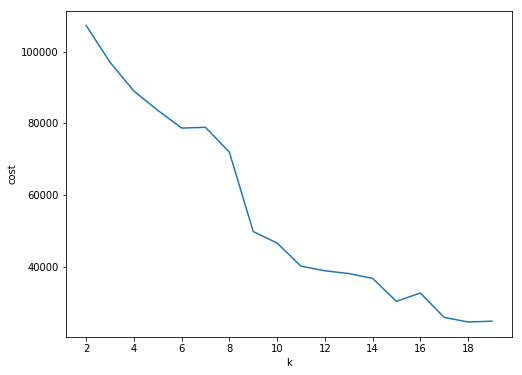

In [88]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20), cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [99]:
from pyspark.mllib.clustering import KMeans, KMeansModel

cluster_centers = []

# Build the model (cluster the data)
for k in range(2, 20):
    clusters = KMeans.train(projected.rows,
                            k,
                            maxIterations=10,
                            initializationMode="random",
                            seed=50,
                            initializationSteps=5,
                            epsilon=1e-4)
    
    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return np.sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = projected.rows.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(k, WSSSE))
    
    centers = clusters.clusterCenters
    
    cluster_centers.append(centers)

The cluster 2 has Within Set Sum of Squared Error 4823.021274247219
The cluster 3 has Within Set Sum of Squared Error 4387.998345685931
The cluster 4 has Within Set Sum of Squared Error 4256.13825006285
The cluster 5 has Within Set Sum of Squared Error 4080.281104223183
The cluster 6 has Within Set Sum of Squared Error 3988.230350846497
The cluster 7 has Within Set Sum of Squared Error 3873.991759078907
The cluster 8 has Within Set Sum of Squared Error 3705.6236035097413
The cluster 9 has Within Set Sum of Squared Error 3540.0673188317414
The cluster 10 has Within Set Sum of Squared Error 3476.484337574137
The cluster 11 has Within Set Sum of Squared Error 3449.453609030289
The cluster 12 has Within Set Sum of Squared Error 3295.1710501640355
The cluster 13 has Within Set Sum of Squared Error 3222.591555734098
The cluster 14 has Within Set Sum of Squared Error 3226.8994041174474
The cluster 15 has Within Set Sum of Squared Error 3092.400575789525
The cluster 16 has Within Set Sum of Sq

In [102]:
print("Cluster Centers: ")
for center in cluster_centers:
    print(center)
    pass

Cluster Centers: 
[array([-0.35066664, -2.14881781,  2.58578343, -3.15835085,  3.5016041 ,
       -1.00266557,  2.04976117, -0.16971094, -1.17573206]), array([ -0.16818695, -18.46616551,  -0.59886053,  -5.12680615,
         2.00493016,  -1.07937699,   1.94545477,  -0.49787848,
        -1.18441366])]
[array([  2.31059817, -18.77503416,  -1.79188034,  -4.07715722,
         2.75395415,  -1.15332057,   2.18339472,  -0.63847296,
        -0.95701754]), array([ 1.20094414, -4.89940732, 10.62167216, -2.16464957,  5.11170978,
       -0.98906816,  1.96475451, -0.10449745, -1.32175217]), array([-1.25622583, -1.50531037,  0.32542046, -3.67367258,  2.86061124,
       -0.99477764,  2.03163322, -0.1692877 , -1.17216142])]
[array([-0.31926739, -1.91629655,  1.3855612 , -2.60478996,  2.19398374,
       -0.87252989,  1.48125484, -0.20778464, -1.19023181]), array([ 1.65619692, -6.12490644, 14.83156545, -3.02734973,  6.72330146,
       -1.1617165 ,  2.27270386, -0.19090936, -1.91260468]), array([ -8.03629

In [101]:
projected.rows.collect()

[DenseVector([-0.798, 0.4959, -1.4349, -5.8544, 4.749, -4.4458, 5.7203, 1.0836, -1.2232]),
 DenseVector([-0.0212, -1.2159, 2.0378, -1.6511, 1.7159, -1.5295, 1.9018, -0.2918, -0.7212]),
 DenseVector([0.049, 0.001, 1.0498, -0.5103, -0.1063, -0.0014, -0.2126, -0.0804, -0.5095]),
 DenseVector([-0.562, 0.505, -0.7182, -2.3413, 1.5599, -1.5734, 6.3541, 0.4712, -1.2868]),
 DenseVector([-0.1648, -1.0457, 1.2865, -4.185, 4.6254, -0.4807, 8.0099, 1.2758, -4.1528]),
 DenseVector([0.6391, -5.0292, 2.2091, -6.4161, 3.1272, -5.0861, -2.2482, -2.013, 3.1563]),
 DenseVector([-0.6199, -1.6062, 0.7704, -6.8163, 1.7418, -2.4822, 2.8575, -4.2479, 0.2148]),
 DenseVector([1.18, -4.2722, 10.3202, 1.92, 9.368, -2.5622, -0.8421, 1.6117, 1.2408]),
 DenseVector([0.3606, -1.7759, 2.6772, -0.9527, 2.6091, -0.0246, 2.1886, 0.0954, 0.715]),
 DenseVector([-0.2765, -0.4404, 1.5702, -2.5804, 2.6432, 0.0584, 2.7393, -2.0724, -1.2797]),
 DenseVector([-2.3301, 1.6381, -2.1775, -3.9694, 3.0728, -1.3514, 0.9249, -0.9751, -0

ValueError: x and y must be the same size

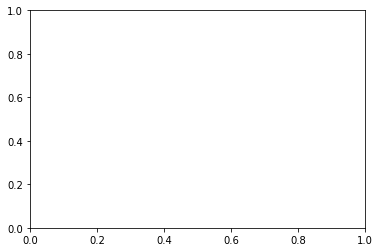

In [110]:
rdd_split_int = projected.rows.map(lambda x: [float(x[0]), float(x[1]), float(x[2]), float(x[3]), float(x[4]), float(x[5]), float(x[6]), float(x[7]), float(x[8])])

# Convert rdd_split_int RDD into Spark DataFrame
rdd_split_int_df = spark.createDataFrame(rdd_split_int, schema=["col1", "col2", "col3", "col4", "col5", "col6", "col7", "col8", "col9"])

# Convert Spark DataFrame into Pandas DataFrame
rdd_split_int_df_pandas = rdd_split_int_df.toPandas()

# Convert "cluster_centers" that you generated earlier into Pandas DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers[8], columns=["col1", "col2", "col3", "col4", "col5", "col6", "col7", "col8", "col9"])

# Create an overlaid scatter plot
plt.scatter(rdd_split_int_df_pandas, cluster_centers_pandas, color="red", marker="x")
plt.show()

In [ ]:
sc.stop()

# Clustering 

[Ref - Scikit learn](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

### Elbow method and Silhouette method

# Classification and cross validation using Multi-Layer Perceptrons

### F Score, Precision, Recall, and Accuracy

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    

In [ ]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(400, 100), max_iter=200, random_state=1)


In [ ]:
start_time = datetime.now()
clf.fit(X_train, y_train)
end_time = datetime.now()
print(f'training time taken:{end_time-start_time}')


In [ ]:
start_time = datetime.now()
pred = cross_val_predict(clf, X_train, y_train, n_jobs=-1)
end_time = datetime.now()
print(f'cross validation time taken:{end_time-start_time}')
classification_report("MLP Report (Training Set)", y_train, sgd_pred)


In [ ]:
start_time = datetime.now()
pred = cross_val_predict(clf, X_test, y_test, cv=3, n_jobs=-1)
end_time = datetime.now()
print(f'test time taken:{end_time-start_time}')


In [ ]:
classification_report("MLP Report (Test Set)", y_test, sgd_pred)


In [ ]:
cv_score = cross_val_score(clf, X.toarray(), y_pred, cv=10)


In [ ]:
print("Mean cv Score - MLP: {:,.3f}".format(float(cv_score.mean()) * 100), "%")


## Bonus: Find top N closest words for given input query

In [40]:
#Generate doc
localDoc = abstracts['abstract']
doc = sc.parallelize(localDoc).map(lambda line: line.split(" "))

AttributeError: 'NoneType' object has no attribute 'sc'

In [41]:
from pyspark.mllib.feature import Word2Vec
start_time = datetime.now()
# Learn a mapping from words to Vectors.
model = Word2Vec().fit(doc)
end_time = datetime.now()
print(f'Word2Vec model fit on the {len(abstracts)} abstracts. Time Taken: {end_time - start_time}')

NameError: name 'doc' is not defined

In [67]:
word = "corona"
topN = 10
synonyms = model.findSynonyms(word, topN)
result = [(s[0], s[1]) for s in synonyms]

# Visualization and stuff

https://cdn.oreillystatic.com/en/assets/1/event/261/Text%20analytics%20and%20new%20visualization%20techniques%20Presentation.pdf

# References

1. [COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/)
2. [How to build a topic-based search engine](https://www.smithinst.co.uk/insights/build-topic-based-search-engine/)
3. W. Buntine et al., "A Scalable Topic-Based Open Source Search Engine," IEEE/WIC/ACM International Conference on Web Intelligence (WI'04), Beijing, China, 2004, pp. 228-234.
4. [Semantic Topic Modeling for Search Queries at Google](https://gofishdigital.com/semantic-topic-modeling/)
5. GRANT, C.; PAZHAYIDAM GEORGE, C.; KANJILAL, V.; NIRKHIWALE, S.; WILSON, J.; WANG, D.. A Topic-Based Search, Visualization, and Exploration System. Florida Artificial Intelligence Research Society Conference, North America, apr. 2015. Available at: <https://www.aaai.org/ocs/index.php/FLAIRS/FLAIRS15/paper/view/10445/10360>. Date accessed: 25 Apr. 2020.